# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.subplots as sub
import dash
from dash import dcc, html, Output, Input, State
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix, top_k_accuracy_score
from sklearn.model_selection import StratifiedKFold
import optuna
from optuna.trial import TrialState
#from optuna.integration import PyTorchIgnitePruningHandler

from functools import partial
import random
import os
import itertools
from PIL import Image
from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torchvision
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset
from torchvision.models import vgg16_bn, resnet50, resnet18, efficientnet_b0, densenet121, ResNet50_Weights, ResNet18_Weights, VGG16_BN_Weights, DenseNet121_Weights, EfficientNet_B0_Weights
from torchvision.utils import make_grid, draw_bounding_boxes, draw_segmentation_masks, draw_keypoints
from torchvision import datasets
from torchvision.transforms import ToTensor, v2, ToPILImage
from torchvision.io import decode_image

# from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
# from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
# from ignite.handlers import ModelCheckpoint, EarlyStopping

from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torch.amp import GradScaler, autocast

from transformers import ViTForImageClassification, ViTImageProcessor, AutoModelForImageClassification, AutoImageProcessor, Trainer, TrainingArguments
from huggingface_hub import snapshot_download, hf_hub_download
import socket
import json
import sys
import io
import base64

# ROOT

## Save torchvision's fine grained visual classification aircraft dataset into your local drive 

## May take up to 10 minutes to download if you have not done so!

In [4]:
# # Starting from chocp/, go up two levels to parent_dir/
# parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# # Prepend to sys.path so Python can find src/
# if parent_dir not in sys.path:
#     sys.path.insert(0, parent_dir)

# from src.chocp_dataset import FGVCAircraftDataset
cache_dir = Path.home() / "Capstone" / "FGVCAircraft"
cache_dir.mkdir(parents=True, exist_ok=True)
datasets.FGVCAircraft(root = str(cache_dir), download=True)
#ROOT = 'c:\\Users\\chihp\\UMich\\SIADS\\699\\FGVC\\fgvc-aircraft-2013b\\data'
ROOT = cache_dir / "fgvc-aircraft-2013b" / "data"
ROOT

WindowsPath('C:/Users/chihp/Capstone/FGVCAircraft/fgvc-aircraft-2013b/data')

In [2]:
from src.functools import FGVCAircraftDataset, get_datasets, get_loaders


ModuleNotFoundError: No module named 'src.functools'

# Detect CUDA GPU if available

In [5]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Class and Function 

In [6]:

class FGVCAircraftDataset(Dataset):
    """
    A customised Fine Grained Visual Categorization Aircraft Dataset for manufacturer / family / variant annotation labels 
    similar to torchvision.datasets.FGVCAircraft dataset.
    
    Args:
        root_dir (str): path to  'fgvc-aircraft-2013b/data' folder
        split   (str): one of 'train', 'trainval', 'val' or 'test' 
        level   (str): one of 'manufacturer', 'family', or 'variant'.
        transform (callable, optional): a torchvision.transforms pipeline or Albumentation pipeline to apply to the images.
        return_label_str (bool): if True, __getitem__ returns (img, label_str) instead of (img, label_idx).
        use_cropped (bool): if True, __getitem__ returns cropped images using bounding box coordinates.
    """
    ALLOWED = {"manufacturer", "family", "variant"}
    
    def __init__(self, root= ROOT, split = "train", level = "manufacturer",
                 transform = None, return_class = False, cropped = False, album = False):
        assert level in self.ALLOWED, f"level must be one of {self.ALLOWED}"
        self.root = root
        self.split    = split
        self.level    = level
        self.transform = transform
        self.return_class = return_class
        self.cropped = cropped
        self.album = album

        # 1) read lines from images_{level}_{split}.txt
        class_file = os.path.join(root,
                                  f"images_{level}_{split}.txt")
        if not os.path.isfile(class_file):
            raise FileNotFoundError(f"{class_file} not found")

        samples = []
        with open(class_file, "r") as f:
            for ln in f:
                parts = ln.strip().split()
                img_id, *label_parts = parts
                class_str = " ".join(label_parts)
                samples.append((img_id, class_str))
        self.samples = samples

        # 2) build label→idx map
        self.classes = sorted({lbl for _, lbl in samples})
        self.class_to_idx = {lbl: i for i, lbl in enumerate(self.classes)}
        self.idx_to_class = {i: lbl for lbl, i in self.class_to_idx.items()}

        # 3) read bounding box coordinates from bounding_boxes_{split}.txt
        bbox_file = os.path.join(root, "images_box.txt")
        if not os.path.isfile(bbox_file):
            raise FileNotFoundError(f"{bbox_file} not found")

        self.bboxes = {}
        with open(bbox_file, "r") as f:
            for ln in f:
                parts = ln.strip().split()
                img_id = parts[0]
                bbox = tuple(map(int, parts[1:]))
                self.bboxes[img_id] = bbox

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_id, class_str = self.samples[idx]
        img_path = os.path.join(self.root, "images", f"{img_id}.jpg")
        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img)

        if self.cropped:
            xmin, ymin, xmax, ymax = self.bboxes[img_id]
            img = img.crop((xmin, ymin, xmax, ymax))

        if self.transform:
            if not self.album:
                img = self.transform(img) #pytorch transoform
            else:
                aug = self.transform(image = img_np)
                img = aug['image'] # albumentations

        if self.return_class:
            return img, class_str

        class_idx = self.class_to_idx[class_str]
        return img, class_idx

In [7]:
# Simple CNN Backbone
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=30, attention_module=None):#, p_conv = 0.2, p_fc = 0.5
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # 224x224 -> 224x224
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 112x112
            #nn.Dropout2d(p_conv), # spatial dropout

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 112x112
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 56x56

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 56x56
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 28x28
            #nn.Dropout2d(p_conv),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # 28x28
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 14x14

            nn.Conv2d(512, 1024, kernel_size=3, padding=1),  # 14x14
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))  # B, 1024, 1, 1
        )
        self.attention = attention_module(1024) if attention_module else nn.Identity() 
        #self.dropout_fc = nn.Dropout(p_fc)
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features(x) #Bx1024x1x1
        #if self.attention:
        x = self.attention(x) # or Identity
        x = x.view(x.size(0), -1) #Bx1024
        #x = self.dropout_fc(x)
        x = self.classifier(x)
        return x

In [8]:
#BCNN Module
class BCNN(nn.Module):
    def __init__(self, num_classes=30, attention_module=None):
        super(BCNN, self).__init__()

        # Custom feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # [B, 64, 224, 224]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 64, 112, 112]

            nn.Conv2d(64, 128, kernel_size=3, padding=1),# [B, 128, 112, 112]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 128, 56, 56]

            nn.Conv2d(128, 256, kernel_size=3, padding=1),# [B, 256, 56, 56]
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))                 # [B, 256, 1, 1]
        )
        
        self.attention = attention_module(256) if attention_module else nn.Identity()
        self.output_dim = 256
        self.fc = nn.Linear(self.output_dim * self.output_dim, num_classes)

    def forward(self, x):
        x = self.features(x)  # [B, 256, 1, 1]
        x = self.attention(x) # Apply attention if provided
        x = x.view(x.size(0), self.output_dim)  # [B, 256]

        # Bilinear pooling
        x = torch.bmm(x.unsqueeze(2), x.unsqueeze(1))  # [B, 256, 256]
        x = x.view(x.size(0), -1)  # [B, 256*256]

        # Signed square root normalization
        x = torch.sign(x) * torch.sqrt(torch.abs(x) + 1e-10)

        # L2 normalization
        x = F.normalize(x)

        # Classification
        x = self.fc(x)
        return x

In [9]:
# CAP Module
class CAP(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CAP, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        context = self.global_avg_pool(x)
        attention = self.fc1(context)
        attention = self.relu(attention)
        attention = self.fc2(attention)
        attention = self.sigmoid(attention)
        return x * attention

# SE Module
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        # Channel Attention
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        self.sigmoid_channel = nn.Sigmoid()

        # Spatial Attention
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        # Channel Attention
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        channel_att = self.sigmoid_channel(avg_out + max_out)
        x = x * channel_att

        # Spatial Attention
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = torch.cat([avg_pool, max_pool], dim=1)
        spatial_att = self.sigmoid_spatial(self.conv_spatial(spatial_att))
        x = x * spatial_att

        return x

In [10]:
class CAPResNet(nn.Module):
    def __init__(self, num_classes=30, drop=0.0):
        super(CAPResNet, self).__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone.fc = nn.Identity()
        self.cap = CAP(in_channels=2048)
        self.dropout = nn.Dropout(drop)
        self.classifier = nn.Linear(2048, num_classes)
    def forward(self, x):
        x = self.backbone(x)
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.cap(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x


# ResNet50 with SE Block
class SEEffNet(nn.Module):
    def __init__(self, num_classes=30, drop=0.0):
        super(SEEffNet, self).__init__()
        self.backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        self.backbone.classifier = nn.Identity() # fc if resnet
        self.se = SEBlock(in_channels=1280) #2048 for resnet, 1280 for efficientnet, densenet121 = 1024, final layer also classifier
        self.dropout = nn.Dropout(drop)
        self.classifier = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.se(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

# ResNet50 with CBAM Block
class CBAMResNet(nn.Module):
    def __init__(self, num_classes=30):
        super(CBAMResNet, self).__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone.fc = nn.Identity()
        self.cbam = CBAM(in_channels=2048)
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.cbam(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# ResNet50 with BCNN Block (Bilinear CNN)
class BCNNResNet(nn.Module):
    def __init__(self, num_classes=30):
        super(BCNNResNet, self).__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone.fc = nn.Identity() # Remove final fully connected layer
        self.output_dim = 2048 # resnet50 final feature depth
        self.classifier = nn.Linear(self.output_dim * self.output_dim, num_classes)

    def forward(self, x):
        x = self.backbone(x) # extract features Bx2048
        x = x.unsqueeze(-1).unsqueeze(-1) # Bx2048x1x1
        x = x.view(x.size(0), self.output_dim) # Bx2048
        x = torch.bmm(x.unsqueeze(2), x.unsqueeze(1)) # Bilinear pooling
        x = x.view(x.size(0), -1) # Bx2048*2048
        x = torch.sign(x) * torch.sqrt(torch.abs(x) + 1e-10) # signed square root normalization
        x = F.normalize(x) # L2 normalization
        x = self.classifier(x) # classification
        return x

In [11]:
# Loss functions
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        log_probs = nn.functional.log_softmax(pred, dim=-1)
        nll_loss = -log_probs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = (1 - self.smoothing) * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, pred, target):
        ce_loss = nn.functional.cross_entropy(pred, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()


In [12]:
def get_loaders(img_size = 224, batch_size = 32, annot = 'manufacturer'):
    mean=[0.485,0.456,0.406]
    std=[0.229,0.224,0.225]

    # train_tf = A.Compose([
    #     A.RandomResizedCrop((img_size, img_size)),  # A.Resize(img_size, img_size)
    #     A.HorizontalFlip(p=0.5),
    #     A.Affine(scale=(0.9, 1.1), translate_percent=(0.05, 0.05), rotate=(-15, 15), p=0.5),
    #     A.RandomBrightnessContrast(p=0.5),
    #     A.Normalize(mean=mean, std=std),
    #     ToTensorV2()
    # ])
    train_tf = A.Compose([
    A.RandomResizedCrop((img_size, img_size)),
    A.HorizontalFlip(p=0.5),
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.05, 0.05), rotate=(-15, 15), p=0.5),
    
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),
        A.MotionBlur(blur_limit=(3, 5), p=0.3),
        A.GaussNoise(
            std_range=(0.02, 0.1),  # Adjusted for subtle noise
            mean_range=(0.0, 0.0),
            per_channel=True,
            noise_scale_factor=1.0,
            p=0.3
        )
    ], p=0.3),
    
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    
    A.CoarseDropout(
        num_holes_range=(1, 8),
        hole_height_range=(8, 16),
        hole_width_range=(8, 16),
        fill=0,
        p=0.5
    ),
    
    A.Perspective(scale=(0.05, 0.1), p=0.3),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
    ])
    test_tf = A.Compose([
        #A.LongestMaxSize(max_size=256)
        A.Resize(img_size, img_size),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])

    
    train_dataset = FGVCAircraftDataset(root=ROOT, split='train', level = annot, transform=train_tf, 
                                        return_class=False, cropped=True, album = True)
    val_dataset   = FGVCAircraftDataset(root=ROOT, split='val', level = annot, transform=test_tf, 
                                        return_class=False, cropped=False, album = True)
    test_dataset   = FGVCAircraftDataset(root=ROOT, split='test', level = annot, transform=test_tf, 
                                         return_class=False, cropped=False, album = True)
    class_names = train_dataset.classes
    num_classes = len(train_dataset.classes)
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
    return train_loader, val_loader, test_loader, num_classes, class_names

In [13]:
def get_datasets(img_size = 224, batch_size = 32, annot = 'manufacturer'):
    mean=[0.485,0.456,0.406]
    std=[0.229,0.224,0.225]

    # train_tf = A.Compose([
    #     A.RandomResizedCrop((img_size, img_size)),  # A.Resize(img_size, img_size)
    #     A.HorizontalFlip(p=0.5),
    #     A.Affine(scale=(0.9, 1.1), translate_percent=(0.05, 0.05), rotate=(-15, 15), p=0.5),
    #     A.RandomBrightnessContrast(p=0.5),
    #     A.Normalize(mean=mean, std=std),
    #     ToTensorV2()
    # ])
    
    train_tf = A.Compose([
    A.RandomResizedCrop((img_size, img_size)),
    A.HorizontalFlip(p=0.5),
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.05, 0.05), rotate=(-15, 15), p=0.5),
    
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),
        A.MotionBlur(blur_limit=(3, 5), p=0.3),
        A.GaussNoise(
            std_range=(0.02, 0.1),  # Adjusted for subtle noise
            mean_range=(0.0, 0.0),
            per_channel=True,
            noise_scale_factor=1.0,
            p=0.3
        )
    ], p=0.3),
    
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    
    A.CoarseDropout(
        num_holes_range=(1, 8),
        hole_height_range=(8, 16),
        hole_width_range=(8, 16),
        fill=0,
        p=0.5
    ),
    
    A.Perspective(scale=(0.05, 0.1), p=0.3),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
    ])

    test_tf = A.Compose([
        #A.LongestMaxSize(max_size=256)
        A.Resize(img_size, img_size),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])

    train_dataset = FGVCAircraftDataset(root=ROOT, split='train', level = annot, transform=train_tf, 
                                        return_class=False, cropped=True, album = True)
    val_dataset   = FGVCAircraftDataset(root=ROOT, split='val', level = annot, transform=test_tf, 
                                        return_class=False, cropped=False, album = True)
    test_dataset   = FGVCAircraftDataset(root=ROOT, split='test', level = annot, transform=test_tf, 
                                         return_class=False, cropped=False, album = True)
    class_names = train_dataset.classes
    num_classes = len(train_dataset.classes)
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
    return train_dataset, val_dataset, test_dataset

In [14]:
# For evaluation of valid set
def top_k_accuracy(output, target, k=5):
    with torch.no_grad():
        max_k_preds = output.topk(k, dim=1)[1]
        correct = max_k_preds.eq(target.view(-1, 1).expand_as(max_k_preds))
        return correct.any(dim=1).float().mean().item()


In [15]:
# For evaluation of final test set

def compute_metrics(y_true, y_pred_logits, k=5):
    """
    Computes Top-1 and Top-k accuracy, and macro/micro F1 scores.
    
    Parameters:
    - y_true: Ground truth labels (list or numpy array)
    - y_pred_logits: Model output logits (tensor or numpy array)
    - k: Value for Top-k accuracy
    
    Returns:
    - Dictionary of metrics
    """
    # Convert logits to predicted labels
    y_pred_top1 = torch.argmax(y_pred_logits, dim=1).cpu().numpy()
    y_true_np = y_true.cpu().numpy() if isinstance(y_true, torch.Tensor) else y_true
    y_pred_np = y_pred_logits.cpu().numpy() if isinstance(y_pred_logits, torch.Tensor) else y_pred_logits

    # Compute metrics
    top1_acc = top_k_accuracy_score(y_true_np, y_pred_np, k=1)
    topk_acc = top_k_accuracy_score(y_true_np, y_pred_np, k=k)
    f1_macro = f1_score(y_true_np, y_pred_top1, average='macro')
    f1_micro = f1_score(y_true_np, y_pred_top1, average='micro')

    return {
        'Top-1 Accuracy': top1_acc,
        f'Top-{k} Accuracy': topk_acc,
        'F1 Macro': f1_macro,
        'F1 Micro': f1_micro
    }



In [16]:
# Training and evaluation functions
def train_one_epoch(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    loss_lst = []
    acc_lst = []

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        #inputs, labels = cutmix_or_mixup(inputs, labels)#cutmix/mixup
        inputs, labels = inputs.to(device), labels.to(device)
        #hard_labels = labels.argmax(dim=1) #convert soft label to hard labels for cutmix or mixup

        optimizer.zero_grad()
        outputs = model(inputs)#
        loss = criterion(outputs, labels)#
        loss.backward()#
        optimizer.step()#
        # with autocast(device_type = 'cuda'):
        #     outputs = model(inputs)
        #     loss = criterion(outputs, labels)
        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()
        

        running_loss += loss.item() * inputs.size(0)
        #hard_labels = labels.argmax(dim=1) #convert soft label to hard labels for cutmix or mixup
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        loss_lst.append(loss.item() * inputs.size(0))#
        acc_lst.append(predicted.eq(labels).sum().item() / labels.size(0))

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    #loss_lst.append(epoch_loss)
    #acc_lst.append(epoch_acc)
    return epoch_loss, epoch_acc, loss_lst, acc_lst

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    loss_lst = []
    acc_lst = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc = "Evaluation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            

            running_loss += loss.item() * inputs.size(0)
            #hard_labels = labels.argmax(dim=1) #convert soft label to hard labels for cutmix or mixup
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            loss_lst.append(loss.item() * inputs.size(0))#
            acc_lst.append(predicted.eq(labels).sum().item() / labels.size(0))

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    #loss_lst.append(epoch_loss)
    #acc_lst.append(epoch_acc)
    return epoch_loss, epoch_acc, all_preds, all_labels, loss_lst, acc_lst



# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def unnormalize(img_tensor, mean, std):
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return img_tensor

def visualize_predictions(model, test_dataset, num_samples=10, normalized=True):
    model.eval()
    samples = random.sample(range(len(test_dataset)), num_samples)
    # Dynamically calculate rows and columns
    cols = 5
    rows = math.ceil(num_samples / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

    axes = axes.flatten()

    inv_label_map = test_dataset.idx_to_class
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    with torch.no_grad():
        for idx, sample_idx in enumerate(samples):
            image, label = test_dataset[sample_idx]
            input_img = image.unsqueeze(0).to(device)
            output = model(input_img)
            _, pred = torch.max(output, 1)

            # Unnormalize if needed
            if normalized:
                image = unnormalize(image.clone(), mean, std)

            img_disp = image.permute(1, 2, 0).cpu().numpy().clip(0, 1)
            axes[idx].imshow(img_disp)
            axes[idx].set_title(f"Pred: {inv_label_map[pred.item()]}\nActual: {inv_label_map[label]}")
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()


In [17]:
# Model selector
def get_model(backbone_name, num_classes, dropout_rate):
    if backbone_name == "ResNet50_CAP":
        return CAPResNet(num_classes=num_classes, drop=dropout_rate)
    elif backbone_name == "EffNet_SE":
        return SEEffNet(num_classes=num_classes, drop=dropout_rate)
    else:
        raise ValueError(f"Unknown backbone: {backbone_name}")

# Objective function
def objective(trial):
    # Hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    backbone_name = trial.suggest_categorical('backbone', ['ResNet50_CAP', 'EffNet_SE'])
    scheduler_name = trial.suggest_categorical('scheduler', ['StepLR', 'CosineAnnealingLR', 'ReduceLROnPlateau'])
    criterion_name = trial.suggest_categorical('criterion', ['CrossEntropy', 'LabelSmoothing', 'Focal'])

    # Data
    train_loader, val_loader, test_loader, num_classes, class_names = get_loaders(img_size=224, batch_size=batch_size, annot='variant')

    # Model
    model = get_model(backbone_name, num_classes, dropout_rate)
    model.to(device)

    # Optimizer
    optimizer_cls = getattr(optim, optimizer_name)
    optimizer = optimizer_cls(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Scheduler
    if scheduler_name == 'StepLR':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    elif scheduler_name == 'CosineAnnealingLR':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    elif scheduler_name == 'ReduceLROnPlateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

    # Criterion 
    if criterion_name == 'CrossEntropy':
        label_smoothing = trial.suggest_float('label_smoothing', 0.0, 0.2)
        criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    elif criterion_name == 'LabelSmoothing':
        smoothing = trial.suggest_float('smoothing', 0.05, 0.2)
        criterion = LabelSmoothingCrossEntropy(smoothing=smoothing)
    elif criterion_name == 'Focal':
        gamma = trial.suggest_float('gamma', 1.0, 3.0)
        criterion = FocalLoss(gamma=gamma)

    scaler = GradScaler('cuda')

    # Training loop
    best_val_loss = float('inf')
    patience = 5
    epochs_without_improvement = 0
    num_epochs = 20
    for epoch in range(num_epochs):
        train_loss, train_acc, _, _ = train_one_epoch(model, train_loader, criterion, optimizer, device, scaler)
        val_loss, val_acc, _, _, _, _ = evaluate(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if scheduler_name == 'ReduceLROnPlateau':
            scheduler.step(val_loss)
        else:
            scheduler.step()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            print("✅ Model improved. Saving...")
        else:
            epochs_without_improvement += 1
            print(f"⚠️ No improvement for {epochs_without_improvement} epoch(s).")
        if epochs_without_improvement >= patience:
            print("⏹️ Early stopping triggered.")
            break

    return val_acc


# Hyper parameter searching with Optuna 
# Warning: Taking more than 12 hours, uncomment to run... ...

In [18]:
# study = optuna.create_study(study_name="Finest_FGVCAircraft_Variant", direction='maximize', 
#                             pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5, interval_steps=3))
# study.optimize(objective, timeout=None, n_jobs=1, n_trials=30, gc_after_trial=False, show_progress_bar=True)

# print("Best trial:")
# trial = study.best_trial
# print(f"  Accuracy: {trial.value}")
# print("  Params:")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# # Visualize optimization results
# optuna.visualization.plot_optimization_history(study, target_name='Accuracy', error_bar=True).show()
# optuna.visualization.plot_param_importances(study).show() # params=["x", "y"]

In [19]:

# # Plot with custom labels
# plt.plot(range(len([t.value for t in study.trials if t.value is not None])), [t.value for t in study.trials if t.value is not None ], marker='o')
# plt.xlabel("Trial")
# plt.ylabel("Validation Accuracy")
# plt.title("Optimization History")
# plt.grid(True)

In [20]:
# optuna.visualization.plot_parallel_coordinate(study, target_name='Accuracy').show()
# optuna.visualization.plot_slice(study, target_name='Accuracy').show()


In [21]:
# optuna.visualization.plot_contour(study, target_name = 'Accuracy').show()
# optuna.visualization.plot_edf(study, target_name = 'Accuracy').show()

In [22]:
# optuna.visualization.plot_intermediate_values(study).show()
# optuna.visualization.plot_rank(study, target_name = 'Accuracy').show()

In [23]:
# optuna.visualization.plot_timeline(study).show()

# DataLoaders and DataSets instantiation

In [24]:
train_loader, val_loader, test_loader, num_classes, class_names = get_loaders(img_size=224,batch_size=16,annot='variant')
train_dataset, val_dataset, test_dataset = get_datasets(224,16,'variant')

In [25]:
num_classes

100

# Model, Loss Func, Optimizer, Scheduler etc.

In [27]:

model=CAPResNet(num_classes, drop = 0.3563).to(device)
# Training loop with early stopping and adaptive learning rate
patience = 8
best_val_loss = float('inf')
epochs_without_improvement = 0
num_epochs = 50
criterion = nn.CrossEntropyLoss(label_smoothing = 0.046858)
# optimizer = optim.RMSprop(model.parameters(), lr=4.9122e-05, weight_decay=0.000126) 
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = num_epochs)
optimizer = optim.Adam(model.parameters(), lr=5.1872e-05, weight_decay=0.002925) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
scaler = GradScaler('cuda')


In [25]:
# #criterion = SoftTargetCrossEntropy() # or nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()#label_smoothing = 0.1)
# optimizer = optim.AdamW(model.parameters(), lr=0.001)
# #optimizer = optim.AdamW(model.parameters(), lr=0.000085, weight_decay = 0.000009)#70
# #optimizer = optim.AdamW(model.parameters(), lr=0.000238, weight_decay = 0.00052)#30
# #optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
# #optimizer = optim.SGD(cnn.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 0.001)
# #optimizer = optim.SGD(filter(lambda p: p.requires_grad, res50.parameters()), lr = 0.001, momentum = 0.9, weight_decay = 0.001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Load the model parameters if existed

In [30]:
# # Load the model
model_file = 'best_model_variant.pth'
model.load_state_dict(torch.load(model_file, weights_only=True))
model.eval()


CAPResNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

# Or start a whole training valuation loop

In [27]:
%%time
train_loss_lst =[]
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []
all_val_preds = []
all_val_labels = []


for epoch in range(num_epochs):

    train_loss, train_acc, t_loss_lst, t__acc_lst = train_one_epoch(model, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_acc, val_preds, val_labels, v_loss_lst, v_acc_lst = evaluate(model, val_loader, criterion, device)
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)
    
    all_val_preds.extend(val_preds)
    all_val_labels.extend(val_labels)


    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


    # Step the scheduler
    #scheduler.step()# for all other schedulers
    scheduler.step(val_loss) # only for 'ReduceLROnPlateau'

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
        print("✅ Model improved. Saving...")
    else:
        epochs_without_improvement += 1
        print(f"⚠️ No improvement for {epochs_without_improvement} epoch(s).")

    if epochs_without_improvement >= patience:
        print("⏹️ Early stopping triggered.")
        break


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/50
Train Loss: 4.5983, Train Acc: 0.0171
Val Loss: 4.5366, Val Acc: 0.0399
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/50
Train Loss: 4.3498, Train Acc: 0.0642
Val Loss: 4.0190, Val Acc: 0.1356
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/50
Train Loss: 3.8826, Train Acc: 0.1356
Val Loss: 3.4794, Val Acc: 0.2130
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/50
Train Loss: 3.3726, Train Acc: 0.2154
Val Loss: 2.9931, Val Acc: 0.3075
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/50
Train Loss: 2.9419, Train Acc: 0.2990
Val Loss: 2.6284, Val Acc: 0.3636
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/50
Train Loss: 2.6515, Train Acc: 0.3629
Val Loss: 2.3672, Val Acc: 0.4278
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 7/50
Train Loss: 2.4281, Train Acc: 0.4127
Val Loss: 2.2053, Val Acc: 0.4485
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 8/50
Train Loss: 2.1978, Train Acc: 0.4688
Val Loss: 2.1147, Val Acc: 0.4785
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 9/50
Train Loss: 2.0654, Train Acc: 0.5174
Val Loss: 2.0282, Val Acc: 0.5086
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 10/50
Train Loss: 1.9807, Train Acc: 0.5342
Val Loss: 1.9466, Val Acc: 0.5209
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 11/50
Train Loss: 1.8844, Train Acc: 0.5651
Val Loss: 1.8053, Val Acc: 0.5515
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 12/50
Train Loss: 1.7829, Train Acc: 0.5948
Val Loss: 1.7518, Val Acc: 0.5551
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 13/50
Train Loss: 1.7410, Train Acc: 0.6149
Val Loss: 1.7226, Val Acc: 0.5788
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 14/50
Train Loss: 1.6409, Train Acc: 0.6377
Val Loss: 1.7023, Val Acc: 0.5836
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 15/50
Train Loss: 1.5676, Train Acc: 0.6587
Val Loss: 1.6485, Val Acc: 0.6100
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 16/50
Train Loss: 1.5228, Train Acc: 0.6752
Val Loss: 1.5873, Val Acc: 0.6136
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 17/50
Train Loss: 1.5130, Train Acc: 0.6770
Val Loss: 1.6485, Val Acc: 0.5980
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 18/50
Train Loss: 1.4769, Train Acc: 0.6965
Val Loss: 1.5807, Val Acc: 0.6103
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 19/50
Train Loss: 1.4202, Train Acc: 0.7007
Val Loss: 1.6310, Val Acc: 0.6025
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 20/50
Train Loss: 1.3925, Train Acc: 0.7193
Val Loss: 1.5951, Val Acc: 0.6268
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 21/50
Train Loss: 1.3377, Train Acc: 0.7316
Val Loss: 1.6288, Val Acc: 0.6250
⚠️ No improvement for 3 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 22/50
Train Loss: 1.3165, Train Acc: 0.7430
Val Loss: 1.5793, Val Acc: 0.6328
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 23/50
Train Loss: 1.2852, Train Acc: 0.7510
Val Loss: 1.6185, Val Acc: 0.6211
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 24/50
Train Loss: 1.2805, Train Acc: 0.7570
Val Loss: 1.6124, Val Acc: 0.6187
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 25/50
Train Loss: 1.2484, Train Acc: 0.7654
Val Loss: 1.5495, Val Acc: 0.6385
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 26/50
Train Loss: 1.2479, Train Acc: 0.7714
Val Loss: 1.5525, Val Acc: 0.6436
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 27/50
Train Loss: 1.2008, Train Acc: 0.7822
Val Loss: 1.6418, Val Acc: 0.6103
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 28/50
Train Loss: 1.1882, Train Acc: 0.7828
Val Loss: 1.5848, Val Acc: 0.6316
⚠️ No improvement for 3 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 29/50
Train Loss: 1.1801, Train Acc: 0.7864
Val Loss: 1.5994, Val Acc: 0.6259
⚠️ No improvement for 4 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 30/50
Train Loss: 1.1767, Train Acc: 0.7903
Val Loss: 1.6516, Val Acc: 0.6145
⚠️ No improvement for 5 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 31/50
Train Loss: 1.1704, Train Acc: 0.7957
Val Loss: 1.6263, Val Acc: 0.6301
⚠️ No improvement for 6 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 32/50
Train Loss: 1.0637, Train Acc: 0.8209
Val Loss: 1.5362, Val Acc: 0.6445
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 33/50
Train Loss: 1.0113, Train Acc: 0.8386
Val Loss: 1.5140, Val Acc: 0.6586
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 34/50
Train Loss: 1.0296, Train Acc: 0.8455
Val Loss: 1.5049, Val Acc: 0.6568
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 35/50
Train Loss: 1.0090, Train Acc: 0.8476
Val Loss: 1.5148, Val Acc: 0.6625
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 36/50
Train Loss: 0.9734, Train Acc: 0.8536
Val Loss: 1.5021, Val Acc: 0.6709
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 37/50
Train Loss: 0.9615, Train Acc: 0.8611
Val Loss: 1.5097, Val Acc: 0.6583
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 38/50
Train Loss: 0.9642, Train Acc: 0.8566
Val Loss: 1.5039, Val Acc: 0.6646
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 39/50
Train Loss: 0.9669, Train Acc: 0.8584
Val Loss: 1.5125, Val Acc: 0.6550
⚠️ No improvement for 3 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 40/50
Train Loss: 0.9945, Train Acc: 0.8503
Val Loss: 1.4850, Val Acc: 0.6673
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 41/50
Train Loss: 0.9485, Train Acc: 0.8674
Val Loss: 1.5239, Val Acc: 0.6631
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 42/50
Train Loss: 0.9505, Train Acc: 0.8671
Val Loss: 1.5175, Val Acc: 0.6601
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 43/50
Train Loss: 0.9304, Train Acc: 0.8746
Val Loss: 1.5441, Val Acc: 0.6571
⚠️ No improvement for 3 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 44/50
Train Loss: 0.9279, Train Acc: 0.8668
Val Loss: 1.5619, Val Acc: 0.6484
⚠️ No improvement for 4 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 45/50
Train Loss: 0.9151, Train Acc: 0.8764
Val Loss: 1.5177, Val Acc: 0.6598
⚠️ No improvement for 5 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 46/50
Train Loss: 0.9006, Train Acc: 0.8839
Val Loss: 1.5512, Val Acc: 0.6574
⚠️ No improvement for 6 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 47/50
Train Loss: 0.8850, Train Acc: 0.8836
Val Loss: 1.4642, Val Acc: 0.6730
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 48/50
Train Loss: 0.8852, Train Acc: 0.8821
Val Loss: 1.4684, Val Acc: 0.6796
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 49/50
Train Loss: 0.8397, Train Acc: 0.8956
Val Loss: 1.4979, Val Acc: 0.6715
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 50/50
Train Loss: 0.8306, Train Acc: 0.9001
Val Loss: 1.4837, Val Acc: 0.6667
⚠️ No improvement for 3 epoch(s).
CPU times: total: 1h 38min 10s
Wall time: 1h 38min 28s


Validation accuracy > Training accuracy:
This is not unusual early in training. It can happen due to:
Regularization effects (e.g., dropout active during training but not during validation).
Batch norm behavior differing between training and inference.
Small training batches causing noisy gradients.
Validation set being easier or more representative early on.

# Final Evaluation on generalizing unseen Test set, 
# Top-k accuracy and F1 scores 

In [31]:
model.eval()
final_preds = []
final_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Final Evaluation", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        final_preds.append(outputs.cpu())
        final_labels.append(labels.cpu())

final_preds = torch.cat(final_preds)
final_labels = torch.cat(final_labels)

final_metrics = compute_metrics(final_labels, final_preds, k=3)
print("Final Evaluation Metrics:")
for key, value in final_metrics.items():
    print(f"{key}: {value:.4f}")

Final Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Final Evaluation Metrics:
Top-1 Accuracy: 0.6970
Top-3 Accuracy: 0.8749
F1 Macro: 0.6954
F1 Micro: 0.6970


# Confusion Matrix

In [32]:
cm = confusion_matrix(all_val_labels, all_val_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_accuracy = np.diag(cm_normalized)
tick_marks = np.arange(len(class_names))

NameError: name 'all_val_labels' is not defined

# CM heatmap along with Lollipop scatter plot

In [ ]:
# Create heatmap using Plotly
heatmap = go.Heatmap(
    z=cm_normalized,
    x=class_names,
    y=class_names,
    colorscale='Plasma',
    colorbar=dict(title='Accuracy'),
    hovertemplate='Actual: %{y}<br>Predicted: %{x}<br>Accuracy: %{z:.2%}<extra></extra>'
)

# Create scatter plot (lollipop style) for class accuracy
scatter = go.Scatter(
    x=class_names,
    y=class_accuracy,
    mode='markers+lines',
    marker=dict(size=8, color='blue'),
    line=dict(color='lightblue'),
    name='Class Accuracy',
    hovertemplate='Class: %{x}<br>Accuracy: %{y:.2%}<extra></extra>'
)

# Create subplots with corrected keyword 'shared_xaxes'
fig = sub.make_subplots(
    rows=2, cols=1,
    row_heights=[0.7, 0.3],
    shared_xaxes=True,
    vertical_spacing=0.05,
    subplot_titles=("Normalized Confusion Matrix", "Accuracy per Class")
)

fig.add_trace(heatmap, row=1, col=1)
fig.add_trace(scatter, row=2, col=1)

fig.update_layout(
    height=1000,
    width=1200,
    title_text="Interactive Confusion Matrix with Variant Level Class Accuracy",
    xaxis2=dict(tickangle=315),
    margin=dict(t=100)
)

# fig.write_html("interactive_confusion_matrix_variant.html")
# print("Interactive confusion matrix with variant level class accuracy saved as 'interactive_confusion_matrix_variant.html'.")
fig.show()


Interactive confusion matrix with variant level class accuracy saved as 'interactive_confusion_matrix_variant.html'.


# Best and Worst 5 classes model predicted

In [31]:
# Zip the class names and accuracies
zipped = list(zip(class_names, class_accuracy))

# Sort by accuracy
sorted_by_accuracy = sorted(zipped, key=lambda x: x[1], reverse=True)

# Get top 5 and bottom 5
top_5 = sorted_by_accuracy[:5]
bottom_5 = sorted_by_accuracy[-5:]
top_5, bottom_5

([('DH-82', 0.9357575757575758),
  ('Spitfire', 0.9133333333333333),
  ('Cessna 525', 0.8935294117647059),
  ('Tornado', 0.8836363636363637),
  ('C-130', 0.8818181818181818)],
 [('737-400', 0.22470588235294117),
  ('767-300', 0.22181818181818183),
  ('757-200', 0.2193939393939394),
  ('747-200', 0.19636363636363635),
  ('737-300', 0.1787878787878788)])

In [32]:
# Create a DataFrame
df = pd.DataFrame({'Class Name': class_names, 'Accuracy': class_accuracy})

# Sort by accuracy
df_sorted = df.sort_values(by='Accuracy', ascending=False)

df_sorted


,Class Name,Accuracy
57,DH-82,0.935758
95,Spitfire,0.913333
49,Cessna 525,0.893529
96,Tornado,0.883636
42,C-130,0.881818
...,...,...
4,737-400,0.224706
17,767-300,0.221818
14,757-200,0.219394
11,747-200,0.196364


Visualization saved as 'variant_class_accuracy_visualization.png'.


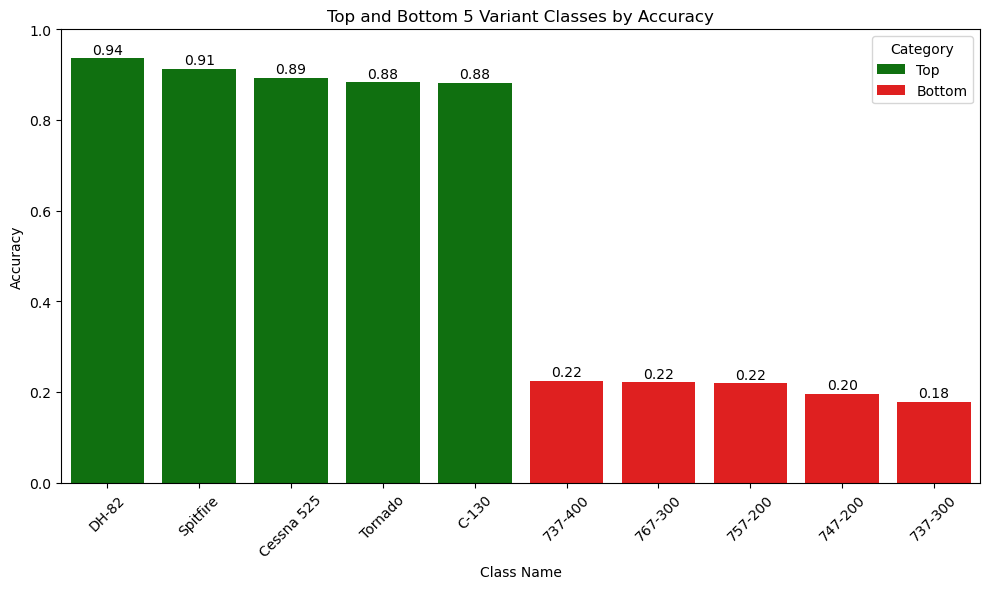

In [ ]:
df_sorted = df_sorted.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Extract top 5 and bottom 5 classes
top5 = df_sorted.head(5).copy()
bottom5 = df_sorted.tail(5).copy()
top5['Category'] = 'Top'
bottom5['Category'] = 'Bottom'
df_vis = pd.concat([top5, bottom5], ignore_index=True)

# Plot 1: Seaborn barplot of accuracy with color-coded categories
plt.figure(figsize=(10, 6))
sns.barplot(data=df_vis, x='Class Name', y='Accuracy', hue='Category', dodge=False, palette={'Top': 'green', 'Bottom': 'red'})
plt.title('Top and Bottom 5 Variant Classes by Accuracy')
plt.ylim(0, 1)
for i, row in df_vis.iterrows():
    plt.text(i, row['Accuracy'] + 0.01, f"{row['Accuracy']:.2f}", ha='center')
plt.xticks(rotation=45)
plt.tight_layout()

#Save the plot
# plt.savefig("variant_class_accuracy_visualization.png")
# print("Visualization saved as 'variant_class_accuracy_visualization.png'.")



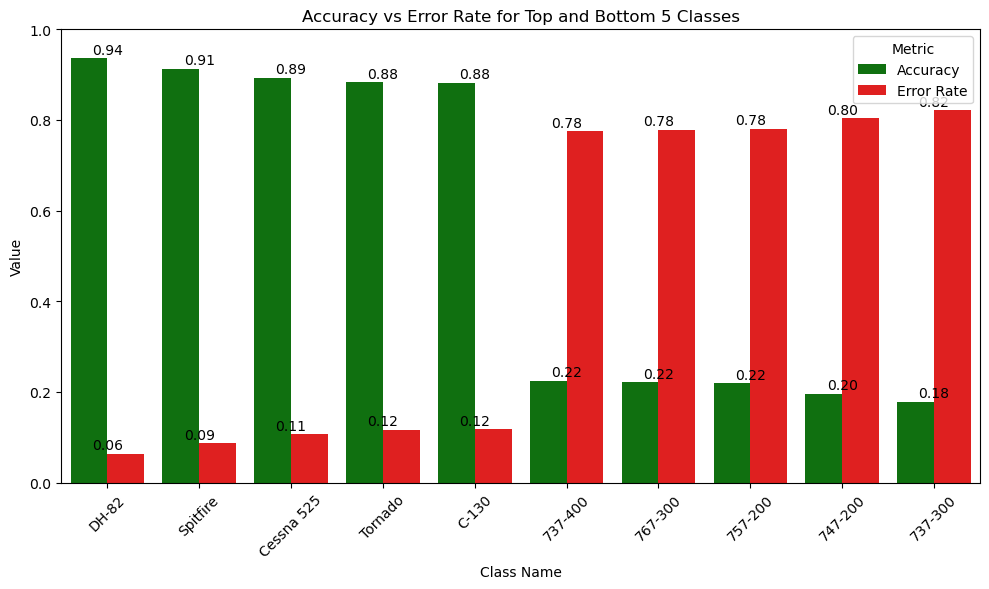

In [34]:
df_vis['Error Rate'] = 1 - df_vis['Accuracy']
df_melted = df_vis.melt(id_vars=['Class Name'], value_vars=['Accuracy', 'Error Rate'], var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Class Name', y='Value', hue='Metric', palette={'Accuracy': 'green', 'Error Rate': 'red'})
plt.title('Accuracy vs Error Rate for Top and Bottom 5 Classes')
plt.ylim(0, 1)
for i, row in df_melted.iterrows():
    plt.text(i % 10, row['Value'] + 0.01, f"{row['Value']:.2f}", ha='center')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig("accuracy_error_comparison.png")
# plt.close()

# print("Visualizations saved as 'accuracy_barplot.png' and 'accuracy_error_comparison.png'.")




# Training and Validation Loss vs Accuracy across epochs

Visualization saved as 'variant_train_val_loss_acc.png'.


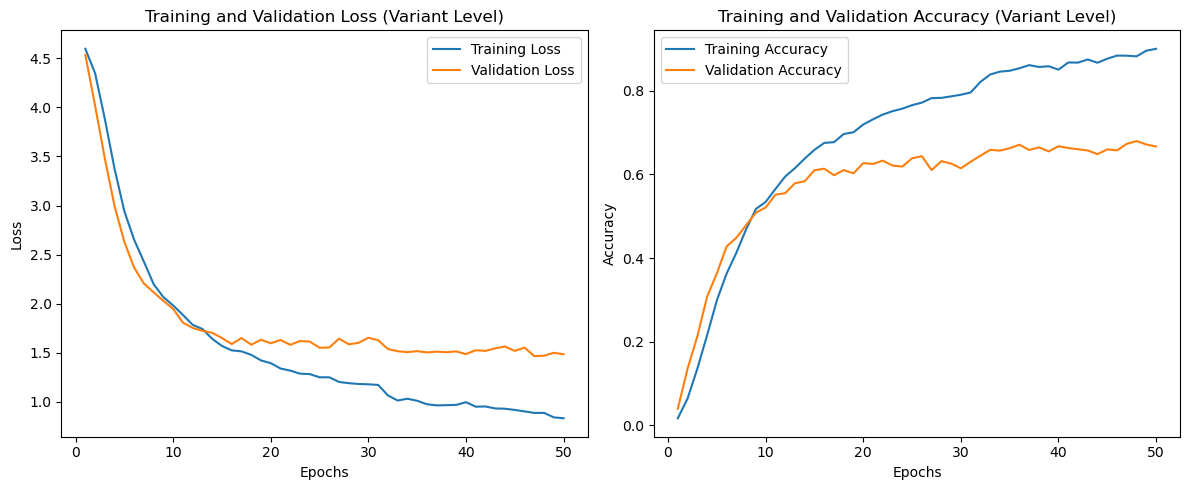

In [ ]:

ep = range(1, len(train_loss_lst) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ep, train_loss_lst, label='Training Loss')
plt.plot(ep, val_loss_lst, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Variant Level)')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(ep, train_acc_lst, label='Training Accuracy')
plt.plot(ep, val_acc_lst, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Variant Level)')
plt.legend()

plt.tight_layout()
# plt.savefig("variant_train_val_loss_acc.png")
# print("Visualization saved as 'variant_train_val_loss_acc.png'.")

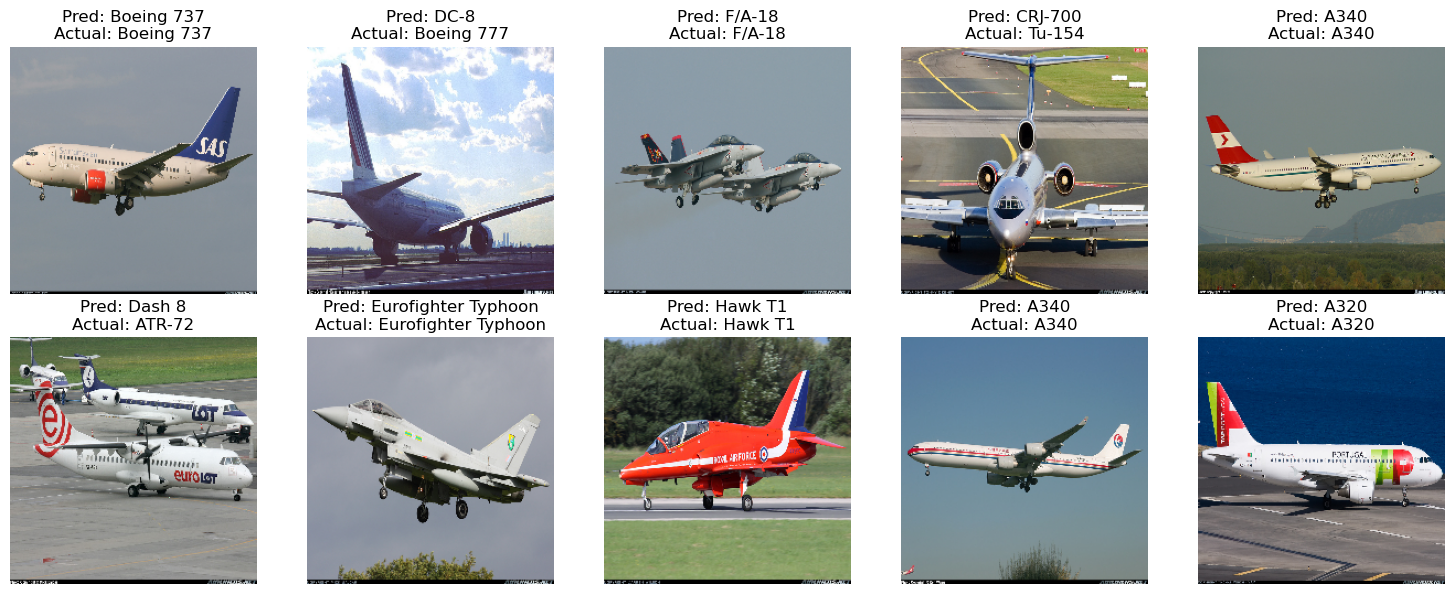

In [36]:
visualize_predictions(model, test_dataset, 10)

# Dashboard with UI production

# safe prediction only workable

In [39]:
# app = dash.Dash(__name__)

# app.layout = html.Div([
#     html.H3("FGVC Aircraft Model Prediction Viewer"),
#     dcc.Input(id='num-samples-input', type='number', min=1, max=50, placeholder='Enter number of samples'),
#     html.Button('Run Prediction', id='predict-button', n_clicks=0),
#     html.Div(id='prediction-output')
# ])

# @app.callback(
#     Output('prediction-output', 'children'),
#     Input('predict-button', 'n_clicks'),
#     State('num-samples-input', 'value')
# )
# def run_prediction(n_clicks, num_samples):
#     if n_clicks > 0 and num_samples:
#         try:
#             # Redirect matplotlib output to buffer
#             buf = io.BytesIO()
#             visualize_predictions(model, test_dataset, num_samples=num_samples)
#             plt.savefig(buf, format='png')
#             plt.close()
#             buf.seek(0)
#             encoded = base64.b64encode(buf.read()).decode('utf-8')
#             img_src = f'data:image/png;base64,{encoded}'
#             return html.Img(src=img_src, style={'width': '100%', 'marginTop': '20px'})
#         except Exception as e:
#             return html.Div(f"Error running prediction: {str(e)}", style={'color': 'red'})
#     return ""

# def find_free_port():
#     s = socket.socket()
#     s.bind(('', 0))
#     return s.getsockname()[1]

# port = find_free_port()



# Ideal dashboard untested

In [ ]:
# from your_module import get_loaders, get_datasets, CAPResNet, train_one_epoch, evaluate, visualize_predictions, FGVCAircraftDataset
app = dash.Dash(__name__)
LEVELS = ['manufacturer', 'family', 'variant']
loaded_datasets = {}
app.layout = html.Div([
    html.H2("FGVC Aircraft Dashboard"),
    dcc.RadioItems(
        id='mode-selector',
        options=[
            {'label': 'Dataset Viewer', 'value': 'viewer'},
            {'label': 'Pre-trained Model', 'value': 'pretrain'},
            {'label': 'Run Training', 'value': 'train'},
            
        ],
        value='viewer',
        inline=True
    ),
    html.Div(id='common-controls', children=[
        html.Label("Select Level:"),
        dcc.Dropdown(id='level-dropdown', options=[{'label': lvl.title(), 'value': lvl} for lvl in LEVELS])
    ]),
    html.Div(id='train-controls', style={'display': 'none'}, children=[
        html.Label("Image Size:"),
        dcc.Input(id='img-size', type='number', value=224),
        html.Label("Batch Size:"),
        dcc.Input(id='batch-size', type='number', value=16),
        html.Label("Annotation Level:"),
        dcc.Dropdown(id='annot-dropdown', options=[{'label': lvl.title(), 'value': lvl} for lvl in LEVELS], value='manufacturer'),
        html.Label("Patience:"),
        dcc.Input(id='patience', type='number', value=8),
        html.Label("Number of Epochs:"),
        dcc.Input(id='num-epochs', type='number', value=50),
        html.Button('Start Training', id='train-button', n_clicks=0),
        html.Div(id='train-status', style={'marginTop': '10px', 'color': 'blue'})
    ]),
    html.Div(id='predict-controls', children=[
        html.Label("Number of Samples to Predict:"),
        dcc.Input(id='num-samples', type='number', min=1, max=50, value=5),
        # html.Br(),
        # html.Label("Select Level:"),
        # dcc.Dropdown(id='lvl-dropdown', options=[{'label': lvl.title(), 'value': lvl} for lvl in LEVELS], value='manufacturer'),
        html.Button('Run Prediction', id='predict-button', n_clicks=0),
        html.Div(id='prediction-output')
    ]),
    html.Div(id='viewer-controls', style={'display': 'none'}, children=[
        html.P(f"Please first download the dataset using torchvision.datasets.FGVCAircraft() "
               "and save it in a directory like {ROOT}. Then input the full path below."),
        dcc.Input(id='path-input', type='text', placeholder='Enter dataset root path', style={'width': '60%'}, value=str(ROOT)),
        html.Button('Load Dataset', id='load-button', n_clicks=0),
        html.Div(id='load-status', style={'marginTop': '10px', 'color': 'green'}),
        html.Br(),
        html.Label("Select Level:"),
        dcc.Dropdown(id='lvl-dropdown', options=[{'label': lvl.title(), 'value': lvl} for lvl in LEVELS], value='manufacturer'),
        html.Label("Select Class:"),
        dcc.Dropdown(id='class-dropdown'),
        html.Div(id='image-output', style={'display': 'flex', 'flexWrap': 'wrap'})
    ]),
    dcc.Store(id='model-meta-store')
])
@app.callback(
    Output('train-controls', 'style'),
    Output('predict-controls', 'style'),
    Output('viewer-controls', 'style'),
    Input('mode-selector', 'value')
)
def toggle_controls(mode):
    return (
        {'display': 'block'} if mode == 'train' else {'display': 'none'},
        {'display': 'block'} if mode in ['train', 'pretrain'] else {'display': 'none'},
        {'display': 'block'} if mode == 'viewer' else {'display': 'none'}
    )
@app.callback(
    [Output('train-status', 'children'),
     Output('model-meta-store', 'data')],
    Input('train-button', 'n_clicks'),
    State('img-size', 'value'),
    State('batch-size', 'value'),
    State('annot-dropdown', 'value'),
    State('patience', 'value'),
    State('num-epochs', 'value')
)
def run_training(n_clicks, img_size, batch_size, annot, patience, num_epochs):
    if n_clicks > 0:
        train_loader, val_loader, test_loader, num_classes, class_names = get_loaders(img_size=img_size, batch_size=batch_size, annot=annot)
        model = CAPResNet(num_classes, drop=0.3563).to('cuda' if torch.cuda.is_available() else 'cpu')
        criterion = nn.CrossEntropyLoss(label_smoothing=0.046858)
        optimizer = optim.Adam(model.parameters(), lr=5.1872e-05, weight_decay=0.002925)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        scaler = GradScaler('cuda')
        best_val_loss = float('inf')
        epochs_without_improvement = 0
        for epoch in range(num_epochs):
            train_loss, train_acc, _, _ = train_one_epoch(model, train_loader, criterion, optimizer, 'cuda', scaler)
            val_loss, val_acc, _, _, _, _ = evaluate(model, val_loader, criterion, 'cuda')
            scheduler.step(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
                torch.save(model.state_dict(), 'best_model_dash.pth')
            else:
                epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                break
        return (
            f"Training completed. Best model saved as best_model_dash.pth with val loss {best_val_loss:.4f}",
            {'num_classes': num_classes, 'class_names': class_names}
        )
    return "", {}
@app.callback(
    Output('prediction-output', 'children'),
    Input('predict-button', 'n_clicks'),
    State('mode-selector', 'value'),
    State('level-dropdown', 'value'),
    State('num-samples', 'value'),
    State('model-meta-store', 'data')
)
def run_prediction(n_clicks, mode, level, num_samples, model_meta):
    if n_clicks > 0 and level:
        try:
            if mode == 'pretrain':
                model_path = f"best_model_{level}.pth"
                _, _, test_loader, num_classes, class_names = get_loaders(img_size=224, batch_size=16, annot=level)
            else:
                num_classes = model_meta.get('num_classes')
                class_names = model_meta.get('class_names')
                if num_classes is None:
                    raise ValueError("Model metadata missing. Please run training first.")
                model_path = 'best_model_dash.pth'
            model = CAPResNet(num_classes, drop=0.3563).to('cuda' if torch.cuda.is_available() else 'cpu')
            model.load_state_dict(torch.load(model_path))
            model.eval()
            test_dataset = get_datasets(224, 16, level)[2]
            buf = io.BytesIO()
            visualize_predictions(model, test_dataset, num_samples=num_samples)
            plt.savefig(buf, format='png')
            plt.close()
            buf.seek(0)
            encoded = base64.b64encode(buf.read()).decode('utf-8')
            img_src = f'data:image/png;base64,{encoded}'
            return html.Img(src=img_src, style={'width': '100%', 'marginTop': '20px'})
        except Exception as e:
            return html.Div(f"Error running prediction: {str(e)}", style={'color': 'red'})
    return ""
@app.callback(
    Output('load-status', 'children'),
    Output('level-dropdown', 'value'),
    Input('load-button', 'n_clicks'),
    State('path-input', 'value')
)
def load_dataset(n_clicks, path):
    if n_clicks > 0 and path:
        try:
            for level in LEVELS:
                loaded_datasets[level] = FGVCAircraftDataset(root=path, split='train', level=level, return_class=True)
            return f"Dataset loaded successfully from: {path}", 'manufacturer'
        except Exception as e:
            return f"Error loading dataset: {str(e)}", None
    return "", None
@app.callback(
    Output('class-dropdown', 'options'),
    Output('class-dropdown', 'value'),
    Input('level-dropdown', 'value')
)
def update_class_dropdown(level):
    if level and level in loaded_datasets:
        dataset = loaded_datasets[level]
        options = [{'label': cls, 'value': cls} for cls in dataset.classes]
        return options, options[0]['value'] if options else None
    return [], None
@app.callback(
    Output('image-output', 'children'),
    Input('level-dropdown', 'value'),
    Input('class-dropdown', 'value')
)
def display_images(level, selected_class):
    if level in loaded_datasets and selected_class:
        dataset = loaded_datasets[level]
        indices = [i for i, (_, cls) in enumerate(dataset.samples) if cls == selected_class]
        if not indices:
            return [html.Div("No images found for this class.", style={'color': 'red'})]

        selected_indices = random.sample(indices, min(5, len(indices)))
        images = []

        for idx in selected_indices:
            img, cls = dataset[idx]
            if isinstance(img, Image.Image):
                buffer = np.array(img)
            else:
                buffer = img.permute(1, 2, 0).numpy()
                buffer = (buffer * 255).astype(np.uint8)  # Convert to uint8 for display

            fig = px.imshow(buffer)
            fig.update_layout(coloraxis_showscale=False, margin=dict(l=0, r=0, t=0, b=0))
            images.append(html.Div(dcc.Graph(figure=fig), style={'margin': '10px'}))

        return images
    return []

def find_free_port():
    s = socket.socket()
    s.bind(('', 0))
    return s.getsockname()[1]

port = find_free_port()   



In [68]:
if __name__ == '__main__':
    app.run(debug=True, port=port)

C:\Users\chihp\AppData\Local\Temp\ipykernel_50184\448000432.py:131: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

